In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install unidecode
# !pip install -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\aisha\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import yaml
from pathlib import Path
import torch
from torch.utils.data import DataLoader, ConcatDataset, Subset, Dataset
from emg2qwerty.data import WindowedEMGDataset
from emg2qwerty.transforms import Compose, ToTensor, LogSpectrogram, SpecAugment, RandomBandRotation, TemporalAlignmentJitter


batch_size = 32
num_workers = 2

# 1. Load the configuration file
config_path = Path("config/user/single_user.yaml")
with open(config_path, 'r') as f:
    first_line = f.readline()
    if first_line.startswith('# @package'):
        cfg = yaml.safe_load(f)
    else:
        f.seek(0)
        cfg = yaml.safe_load(f)

# 2. Set the data root path
data_root = Path("data")

# 3. Create transforms
# Training transforms with augmentation
train_transform = Compose([
    ToTensor(),
    LogSpectrogram(),
    SpecAugment(),
    RandomBandRotation()
])

# Validation/test transforms without augmentation
eval_transform = Compose([
    ToTensor(),
    LogSpectrogram()
])

# 4. Create datasets
train_datasets = []
for session_info in cfg['dataset']['train']:
    session_id = session_info['session']
    file_path = data_root / f"{session_id}.hdf5"

    dataset = WindowedEMGDataset(
        hdf5_path=file_path,
        window_length=2000,  # 1 second at 2kHz
        stride=1000,         # 50% overlap
        padding=(200, 200),  # 100ms context on each side
        jitter=True,         # Apply jitter for training
        transform=train_transform
    )
    train_datasets.append(dataset)

val_datasets = []
for session_info in cfg['dataset']['val']:
    session_id = session_info['session']
    file_path = data_root / f"{session_id}.hdf5"

    dataset = WindowedEMGDataset(
        hdf5_path=file_path,
        window_length=2000,
        stride=1000,
        padding=(200, 200),
        jitter=False,  # No jitter for validation
        transform=eval_transform
    )
    val_datasets.append(dataset)

test_datasets = []
for session_info in cfg['dataset']['test']:
    session_id = session_info['session']
    file_path = data_root / f"{session_id}.hdf5"

    dataset = WindowedEMGDataset(
        hdf5_path=file_path,
        window_length=2000,
        stride=1000,
        padding=(200, 200),
        jitter=False,  # No jitter for testing
        transform=eval_transform
    )
    test_datasets.append(dataset)

# 5. Combine datasets and create DataLoaders
train_dataset = ConcatDataset(train_datasets)
val_dataset = ConcatDataset(val_datasets)
test_dataset = ConcatDataset(test_datasets)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=WindowedEMGDataset.collate,
    num_workers=num_workers
)


val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,  # No shuffle for validation
    collate_fn=WindowedEMGDataset.collate,
    num_workers=num_workers
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,  # No shuffle for testing
    collate_fn=WindowedEMGDataset.collate,
    num_workers=num_workers
)

# for debugging
small_train_loader = DataLoader(
    Subset(train_dataset, list(range(100))),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=WindowedEMGDataset.collate,
    num_workers=num_workers
)

small_val_loader = DataLoader(
    Subset(val_dataset, list(range(100))),
    batch_size=batch_size,
    shuffle=False,  # No shuffle for validation
    collate_fn=WindowedEMGDataset.collate,
    num_workers=num_workers
)

print(f"Created train_loader with {len(train_dataset)} windows")
print(f"Created val_loader with {len(val_dataset)} windows")
print(f"Created test_loader with {len(test_dataset)} windows")


Created train_loader with 30713 windows
Created val_loader with 1698 windows
Created test_loader with 2251 windows


In [4]:
import pandas as pd
import h5py
from pathlib import Path
import yaml
import json

# Load the configuration file
config_path = Path("C:/Users/aisha/OneDrive/Documents/cs247_project/config/user/single_user.yaml")
with open(config_path, 'r') as f:
    # Skip the first line which contains "# @package _global_"
    first_line = f.readline()
    if first_line.startswith('# @package'):
        cfg = yaml.safe_load(f)
    else:
        # If the first line doesn't have the package declaration, reset to beginning of file
        f.seek(0)
        cfg = yaml.safe_load(f)

# Set the data root path (adjust this to your actual data location)
data_root = Path("C:/Users/aisha/OneDrive/Documents/cs247_project/data")  # Update this to your actual data path

# Function to extract metadata from a session file
def extract_session_metadata(file_path):
    try:
        with h5py.File(file_path, 'r') as f:
            emg2qwerty_group = f['emg2qwerty']

            # Get metadata attributes
            metadata = {}
            for key, val in emg2qwerty_group.attrs.items():
                if key in ['keystrokes', 'prompts']:
                    try:
                        metadata[key] = json.loads(val)
                    except json.JSONDecodeError:
                        # Fall back to yaml if json fails
                        metadata[key] = yaml.safe_load(val)
                else:
                    metadata[key] = val

            # Calculate basic statistics
            session_stats = {
                'user': metadata.get('user', 'unknown'),
                'session': metadata.get('session_name', 'unknown'),
                'duration_mins': metadata.get('duration_mins', 0),
                'duration_hours': metadata.get('duration_mins', 0) / 60.0,
                'num_keystrokes': len(metadata.get('keystrokes', [])),
                'num_prompts': len(metadata.get('prompts', [])),
                'split': 'unknown'  # Will be set later
            }

            return session_stats
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

# Collect all sessions from config
all_sessions = []
splits = ['train', 'val', 'test']

for split in splits:
    if split in cfg['dataset']:
        for session_info in cfg['dataset'][split]:
            session_info_dict = {
                'user': session_info['user'],
                'session': session_info['session'],
                'split': split
            }
            all_sessions.append(session_info_dict)

# Process each session to get metadata
session_stats = []

for session_info in all_sessions:
    user_id = session_info['user']
    session_id = session_info['session']
    split = session_info['split']
    file_path = data_root / f"{session_id}.hdf5"

    if file_path.exists():
        stats = extract_session_metadata(file_path)
        if stats:
            stats['split'] = split  # Add which split this session belongs to
            session_stats.append(stats)
    else:
        print(f"Warning: File not found: {file_path}")

# Create a DataFrame from the collected statistics
df = pd.DataFrame(session_stats)
print(df)

# Calculate aggregated statistics per split
split_stats = df.groupby('split').agg({
    'session': 'count',
    'duration_hours': 'sum',
    'num_keystrokes': 'sum',
    'num_prompts': 'sum'
}).rename(columns={'session': 'count'})

# Calculate overall statistics
num_sessions = len(df)
total_duration_hours = df["duration_hours"].sum()
total_keystrokes = df["num_keystrokes"].sum()
total_prompts = df["num_prompts"].sum()

# Print the results
print("Overall statistics:")
print(f"Number of sessions: {num_sessions}")
print(f"Total duration (hours): {total_duration_hours:.2f}")
print(f"Total keystrokes: {total_keystrokes}")
print(f"Total prompts: {total_prompts}")

print("\nStatistics by split:")
print(split_stats)

# Also print individual statistics for train, val, and test sets
for split in splits:
    if split in df['split'].values:
        split_df = df[df['split'] == split]
        print(f"\n{split.capitalize()} set statistics:")
        print(f"Number of sessions: {len(split_df)}")
        print(f"Total duration (hours): {split_df['duration_hours'].sum():.2f}")
        print(f"Total keystrokes: {split_df['num_keystrokes'].sum()}")
        print(f"Total prompts: {split_df['num_prompts'].sum()}")

# Save to CSV files
df.to_csv("all_session_metadata.csv", index=False)
split_stats.to_csv("split_statistics.csv")


        user                                            session  \
0   89335547  2021-06-03-1622765527-keystrokes-dca-study@1-0...   
1   89335547  2021-06-02-1622681518-keystrokes-dca-study@1-0...   
2   89335547  2021-06-04-1622863166-keystrokes-dca-study@1-0...   
3   89335547  2021-07-22-1627003020-keystrokes-dca-study@1-0...   
4   89335547  2021-07-21-1626916256-keystrokes-dca-study@1-0...   
5   89335547  2021-07-22-1627004019-keystrokes-dca-study@1-0...   
6   89335547  2021-06-05-1622885888-keystrokes-dca-study@1-0...   
7   89335547  2021-06-02-1622679967-keystrokes-dca-study@1-0...   
8   89335547  2021-06-03-1622764398-keystrokes-dca-study@1-0...   
9   89335547  2021-07-21-1626917264-keystrokes-dca-study@1-0...   
10  89335547  2021-06-05-1622889105-keystrokes-dca-study@1-0...   
11  89335547  2021-06-03-1622766673-keystrokes-dca-study@1-0...   
12  89335547  2021-06-04-1622861066-keystrokes-dca-study@1-0...   
13  89335547  2021-07-22-1627001995-keystrokes-dca-study@1-0..

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from emg2qwerty.charset import charset

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        # Create position encodings
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x is [seq_len, batch, features]
        return x + self.pe[:x.size(0), :]

In [7]:
class ConvModule(nn.Module):
    def __init__(self, d_model, kernel_size=15, expansion_factor=2, dropout=0.1):
        super().__init__()

        # Pointwise Conv -> Depthwise Conv -> Pointwise Conv
        self.layer_norm = nn.LayerNorm(d_model)
        self.pointwise_conv1 = nn.Conv1d(d_model, d_model * expansion_factor, kernel_size=1)
        self.glu = nn.GLU(dim=1)
        self.depthwise_conv = nn.Conv1d(
            d_model, d_model,
            kernel_size=kernel_size,
            padding=(kernel_size-1)//2,
            groups=d_model
        )
        self.batch_norm = nn.BatchNorm1d(d_model)
        self.swish = nn.SiLU()
        self.pointwise_conv2 = nn.Conv1d(d_model, d_model, kernel_size=1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x is [batch, seq_len, d_model]
        residual = x

        # Layer norm
        x = self.layer_norm(x)

        # Transpose to [batch, d_model, seq_len] for Conv1d
        x = x.transpose(1, 2)

        # Pointwise conv and GLU activation
        x = self.pointwise_conv1(x)
        x = self.glu(x)

        # Depthwise conv
        x = self.depthwise_conv(x)
        x = self.batch_norm(x)
        x = self.swish(x)

        # Pointwise conv
        x = self.pointwise_conv2(x)
        x = self.dropout(x)

        # Transpose back to [batch, seq_len, d_model]
        x = x.transpose(1, 2)

        # Residual connection
        return x + residual

In [8]:
class FeedForwardModule(nn.Module):
    def __init__(self, d_model, expansion_factor=4, dropout=0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(d_model)
        self.linear1 = nn.Linear(d_model, d_model * expansion_factor)
        self.swish = nn.SiLU()
        self.dropout1 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_model * expansion_factor, d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        residual = x

        x = self.layer_norm(x)
        x = self.linear1(x)
        x = self.swish(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.dropout2(x)

        return x + residual

In [9]:
class ConformerBlock(nn.Module):
    def __init__(self, d_model, nhead=8, dropout=0.1, kernel_size=15):
        super().__init__()

        # First feed-forward module (half-step)
        self.feed_forward1 = FeedForwardModule(d_model, dropout=dropout)

        # Multi-headed self-attention
        self.self_attn_layer_norm = nn.LayerNorm(d_model)
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=False)
        self.self_attn_dropout = nn.Dropout(dropout)

        # Convolution module
        self.conv_module = ConvModule(d_model, kernel_size=kernel_size, dropout=dropout)

        # Second feed-forward module (half-step)
        self.feed_forward2 = FeedForwardModule(d_model, dropout=dropout)

        # Final layer norm
        self.final_layer_norm = nn.LayerNorm(d_model)

    def forward(self, x, attention_mask=None):
        """
        Args:
            x: input tensor of shape [seq_len, batch, d_model]
            attention_mask: mask for self-attention of shape [batch, seq_len]
        """
        # Apply first FFN (half step)
        x = x + 0.5 * self.feed_forward1(x)

        # Apply self-attention
        residual = x
        x = self.self_attn_layer_norm(x)

        # For PyTorch's MultiheadAttention when batch_first=False:
        # x shape should be [seq_len, batch, d_model]
        # key_padding_mask should be [batch, seq_len]
        attn_output, _ = self.self_attn(
            x, x, x,
            key_padding_mask=attention_mask  # Already in correct shape [batch, seq_len]
        )

        x = residual + self.self_attn_dropout(attn_output)

        # Apply convolution module
        residual = x
        x_t = x.transpose(0, 1)  # [batch, seq_len, d_model]
        x_t = self.conv_module(x_t)
        x = residual + x_t.transpose(0, 1)  # [seq_len, batch, d_model]

        # Apply second FFN (half step)
        x = x + 0.5 * self.feed_forward2(x)

        # Final layer norm
        x = self.final_layer_norm(x)

        return x

In [10]:
class EMGConformer(nn.Module):
    def __init__(self, num_classes=99, d_model=256, nhead=8, num_layers=4, dropout=0.3):
        super().__init__()
        
        # Input EMG signal dimensions
        self.features = 1056  # 2 bands * 16 channels * 33 frequencies
        
        # CNN feature extraction with output channels = cnn_output_dim
        cnn_output_dim = 256  # This should match your last CNN layer's output channels
        
        self.conv_layers = nn.Sequential(
            nn.Conv1d(self.features, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Conv1d(512, cnn_output_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(cnn_output_dim),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(dropout)
        )
        
        # Add projection layer to ensure dimensions match
        self.projection = nn.Linear(cnn_output_dim, d_model) if cnn_output_dim != d_model else nn.Identity()
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Conformer blocks
        self.conformer_blocks = nn.ModuleList([
            ConformerBlock(d_model, nhead, dropout, kernel_size=15)
            for _ in range(num_layers)
        ])
        
        # Classification head
        self.classifier = nn.Linear(d_model, num_classes)
    
    def forward(self, x, input_lengths=None):
        # x shape: [T, N, B, C, F] - [time, batch, bands, channels, freq]
        T, N, B, C, F = x.shape
        device = x.device
        
        # Flatten features and prepare for Conv1d
        x = x.reshape(T, N, B*C*F).permute(1, 2, 0)  # [N, B*C*F, T]
        
        # Apply CNN layers
        x = self.conv_layers(x)  # [N, cnn_output_dim, T//2]
        
        # Calculate new sequence lengths after CNN pooling 
        if input_lengths is not None:
            new_lengths = torch.div(input_lengths, 2, rounding_mode='floor')
            new_lengths = torch.clamp(new_lengths, min=1)
            # Create padding mask for transformer
            max_len = x.size(2)
            padding_mask = (torch.arange(max_len, device=device).expand(N, max_len) 
                           >= new_lengths.unsqueeze(1))
        else:
            padding_mask = None
        
        # Prepare for conformer: [T//2, N, cnn_output_dim]
        x = x.permute(2, 0, 1)
        
        # Apply projection if needed
        x = self.projection(x)  # [T//2, N, d_model]
        
        # Apply positional encoding
        x = self.pos_encoder(x)
        
        # Apply conformer blocks
        for block in self.conformer_blocks:
            x = block(x, padding_mask)
        
        # Apply classifier
        x = self.classifier(x)
        
        return x

In [11]:
def calculate_cer(predictions, targets):
    """
    Calculate Character Error Rate
    """
    total_edits = 0
    total_length = 0

    for pred, target in zip(predictions, targets):
        # Remove blank tokens and duplicates
        filtered_pred = []
        prev = None
        for p in pred:
            if p != charset().null_class and p != prev:
                filtered_pred.append(p)
            prev = p

        # Calculate edit distance
        edit_distance = levenshtein_distance(filtered_pred, target)

        total_edits += edit_distance
        total_length += len(target)

    # Return CER
    return total_edits / max(1, total_length)

def levenshtein_distance(s1, s2):
    """
    Calculate Levenshtein distance between two sequences
    """
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]

In [12]:
def decode_predictions(log_probs, input_lengths):
    """Perform CTC greedy decoding on log probabilities"""
    predictions = log_probs.argmax(dim=2)
    decoded = []
    
    for i in range(predictions.size(1)):  # Loop through batch
        pred_len = input_lengths[i].item()
        pred = predictions[:pred_len, i].tolist()
        
        # Remove consecutive duplicates and blanks (CTC decoding)
        result = []
        prev = None
        for p in pred:
            if p != 0:  # Not blank
                if p != prev:  # Not a duplicate
                    result.append(p)
            prev = p
        
        decoded.append(result)
    
    return decoded

In [13]:
def train_model(model, train_loader, val_loader, device, epochs=100, lr=0.001, weight_decay=1e-4):
    """
    Train the Conformer model on EMG data
    """
    model = model.to(device)

    # CTC loss for sequence prediction
    criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)

    # Adam optimizer with improved parameters
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.999), eps=1e-8)

    # Learning rate scheduler with warmup
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=0.002,  # Lower max learning rate
        steps_per_epoch=len(train_loader),
        epochs=epochs,
        pct_start=0.1,  # 10% warmup
        div_factor=10,  # Initial lr = max_lr/div_factor
        final_div_factor=100  # Final lr = initial_lr/final_div_factor
    )
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_cer': [],
        'all_predictions': [],
        'all_targets': []
    }

    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_batches = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        for batch_idx, batch in enumerate(progress_bar):
            inputs = batch['inputs'].to(device)
            targets = batch['targets'].to(device)
            input_lengths = batch['input_lengths'].to(device)
            target_lengths = batch['target_lengths'].to(device)

            # Forward pass
            outputs = model(inputs, input_lengths)

            # Compute log probabilities
            log_probs = outputs.log_softmax(2)

            # Adjust input lengths for downsampling in the model
            # We only have one pooling layer with stride 2
            input_lengths = torch.div(input_lengths, 2, rounding_mode='floor')
            input_lengths = torch.clamp(input_lengths, min=1)  # Ensure no zero lengths

            # Compute loss
            loss = criterion(log_probs, targets.T, input_lengths, target_lengths)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

            optimizer.step()
            scheduler.step()

            # Update statistics
            train_loss += loss.item()
            train_batches += 1

            # Update progress bar
            progress_bar.set_postfix({'loss': loss.item()})

        avg_train_loss = train_loss / train_batches
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_batches = 0
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            progress_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
            for batch_idx, batch in enumerate(progress_bar):
                inputs = batch['inputs'].to(device)
                targets = batch['targets'].to(device)
                input_lengths = batch['input_lengths'].to(device)
                target_lengths = batch['target_lengths'].to(device)

                # Forward pass
                outputs = model(inputs, input_lengths)

                # Compute log probabilities
                log_probs = outputs.log_softmax(2)

                # Adjust input lengths for downsampling in the model
                input_lengths = torch.div(input_lengths, 2, rounding_mode='floor')
                input_lengths = torch.clamp(input_lengths, min=1)  # Ensure no zero lengths

                # Compute loss
                loss = criterion(log_probs, targets.T, input_lengths, target_lengths)

                # Update statistics
                val_loss += loss.item()
                val_batches += 1

                # Decode predictions using proper CTC decoding
                predictions = decode_predictions(log_probs.cpu(), input_lengths.cpu())
                targets_np = targets.cpu().numpy()

                # Store predictions and targets for CER calculation
                for i in range(inputs.size(1)):  # Loop through batch
                    target_seq = targets_np[:target_lengths[i].item(), i]
                    all_predictions.append(predictions[i])  # Already processed by decode_predictions
                    all_targets.append(target_seq)

                # Update progress bar
                progress_bar.set_postfix({'loss': loss.item()})

        avg_val_loss = val_loss / val_batches
        history['val_loss'].append(avg_val_loss)

        # Calculate Character Error Rate
        cer = calculate_cer(all_predictions, all_targets)
        history['val_cer'].append(cer)
        history['all_predictions'].append(all_predictions)
        history['all_targets'].append(all_targets)

        # Print epoch summary
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}')
        print(f'  Val Loss: {avg_val_loss:.4f}, Val CER: {cer:.4f}')

    return history

In [16]:
# Define a global resampling ratio variable that can be accessed by the collate function
RESAMPLING_RATIO = 1.0

def resampled_collate(batches):
    """Collate function that applies resampling based on global RESAMPLING_RATIO"""
    batch = WindowedEMGDataset.collate(batches)
    # Apply resampling to inputs
    inputs = batch['inputs']  # [T, N, B, C, F]
    T, N, B, C, F = inputs.shape
    
    # Calculate new time dimension size based on the global ratio
    ratio = RESAMPLING_RATIO
    new_T = int(T * ratio)
    
    # Resample using interpolation
    if ratio < 1.0:  # Downsampling
        # Select evenly spaced time points
        indices = torch.linspace(0, T-1, new_T).long()
        resampled_inputs = inputs[indices]
    else:  # Upsampling (or no change if ratio=1)
        # For simplicity, we'll use linear interpolation
        resampled_inputs = torch.nn.functional.interpolate(
            inputs.permute(1, 2, 3, 0, 4).reshape(N, B*C, T, F),
            size=(new_T, F),
            mode='bilinear',
            align_corners=False
        ).reshape(N, B, C, new_T, F).permute(3, 0, 1, 2, 4)
    
    # Adjust input lengths
    input_lengths = batch['input_lengths']
    new_input_lengths = (input_lengths.float() * ratio).long()
    
    # Create new batch with resampled data
    new_batch = {
        'inputs': resampled_inputs,
        'targets': batch['targets'],
        'input_lengths': new_input_lengths,
        'target_lengths': batch['target_lengths']
    }
    
    return new_batch

class ResampledDataset(Dataset):
    """Dataset wrapper for resampled data"""
    
    def __init__(self, dataset, ratio):
        self.dataset = dataset
        self.ratio = ratio
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        return item

def resample_data_loaders(train_loader, val_loader, ratio):
    """
    Create new data loaders with resampled data
    """
    global RESAMPLING_RATIO
    RESAMPLING_RATIO = ratio
    
    resampled_train_dataset = ResampledDataset(train_loader.dataset, ratio)
    resampled_val_dataset = ResampledDataset(val_loader.dataset, ratio)
    
    # Set num_workers=0 to avoid multiprocessing issues
    resampled_train_loader = DataLoader(
        resampled_train_dataset,
        batch_size=train_loader.batch_size,
        shuffle=True,
        collate_fn=resampled_collate,
        num_workers=0  # Set to 0 to avoid multiprocessing issues
    )
    
    resampled_val_loader = DataLoader(
        resampled_val_dataset,
        batch_size=val_loader.batch_size,
        shuffle=False,
        collate_fn=resampled_collate,
        num_workers=0  # Set to 0 to avoid multiprocessing issues
    )
    
    return resampled_train_loader, resampled_val_loader

Using device: cuda
Testing with sampling rate 500 Hz...


Epoch 1/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.25it/s, loss=1.78] 


Epoch 1/20:
  Train Loss: 1.9486
  Val Loss: 1.3092, Val CER: 0.5275


Epoch 2/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.93it/s, loss=2.92] 


Epoch 2/20:
  Train Loss: 1.3569
  Val Loss: 1.1966, Val CER: 0.4924


Epoch 3/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.14it/s, loss=1.46] 


Epoch 3/20:
  Train Loss: 1.1408
  Val Loss: 0.9411, Val CER: 0.4135


Epoch 4/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.28it/s, loss=0.938]


Epoch 4/20:
  Train Loss: 1.0033
  Val Loss: 0.7964, Val CER: 0.3684


Epoch 5/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.55it/s, loss=1.06] 


Epoch 5/20:
  Train Loss: 0.9247
  Val Loss: 0.7605, Val CER: 0.3709


Epoch 6/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.49it/s, loss=1.35] 


Epoch 6/20:
  Train Loss: 0.8609
  Val Loss: 0.6825, Val CER: 0.3348


Epoch 7/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 20.28it/s, loss=1.32] 


Epoch 7/20:
  Train Loss: 0.8044
  Val Loss: 0.6354, Val CER: 0.3301


Epoch 8/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.79it/s, loss=0.531]


Epoch 8/20:
  Train Loss: 0.7541
  Val Loss: 0.6095, Val CER: 0.3160


Epoch 9/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.61it/s, loss=0.982]


Epoch 9/20:
  Train Loss: 0.7164
  Val Loss: 0.5703, Val CER: 0.3119


Epoch 10/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 20.53it/s, loss=0.309]


Epoch 10/20:
  Train Loss: 0.6742
  Val Loss: 0.5483, Val CER: 0.3085


Epoch 11/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.62it/s, loss=0.291] 


Epoch 11/20:
  Train Loss: 0.6314
  Val Loss: 0.5276, Val CER: 0.2931


Epoch 12/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.77it/s, loss=0.318] 


Epoch 12/20:
  Train Loss: 0.5971
  Val Loss: 0.4649, Val CER: 0.2831


Epoch 13/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.76it/s, loss=0.384] 


Epoch 13/20:
  Train Loss: 0.5579
  Val Loss: 0.4775, Val CER: 0.2791


Epoch 14/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.35it/s, loss=0.262] 


Epoch 14/20:
  Train Loss: 0.5278
  Val Loss: 0.4782, Val CER: 0.2853


Epoch 15/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.56it/s, loss=0.158] 


Epoch 15/20:
  Train Loss: 0.4922
  Val Loss: 0.4523, Val CER: 0.2744


Epoch 16/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.90it/s, loss=0.158]  


Epoch 16/20:
  Train Loss: 0.4699
  Val Loss: 0.4412, Val CER: 0.2718


Epoch 17/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 22.69it/s, loss=0.194]   


Epoch 17/20:
  Train Loss: 0.4497
  Val Loss: 0.4365, Val CER: 0.2688


Epoch 18/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.57it/s, loss=0.108]  


Epoch 18/20:
  Train Loss: 0.4327
  Val Loss: 0.4317, Val CER: 0.2691


Epoch 19/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.91it/s, loss=0.117]  


Epoch 19/20:
  Train Loss: 0.4305
  Val Loss: 0.4303, Val CER: 0.2670


Epoch 20/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.36it/s, loss=0.0962] 


Epoch 20/20:
  Train Loss: 0.4220
  Val Loss: 0.4303, Val CER: 0.2672
Testing with sampling rate 1000 Hz...


Epoch 1/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.31it/s, loss=1.96] 


Epoch 1/20:
  Train Loss: 1.9088
  Val Loss: 1.2095, Val CER: 0.4794


Epoch 2/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.06it/s, loss=0.977]  


Epoch 2/20:
  Train Loss: 1.0816
  Val Loss: 0.7789, Val CER: 0.3838


Epoch 3/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.15it/s, loss=0.869]  


Epoch 3/20:
  Train Loss: 0.8547
  Val Loss: 0.6491, Val CER: 0.3690


Epoch 4/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 20.33it/s, loss=0.794]  


Epoch 4/20:
  Train Loss: 0.7337
  Val Loss: 0.5649, Val CER: 0.3335


Epoch 5/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.89it/s, loss=1.45]  


Epoch 5/20:
  Train Loss: 0.6578
  Val Loss: 0.5445, Val CER: 0.3271


Epoch 6/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.29it/s, loss=1.01]   


Epoch 6/20:
  Train Loss: 0.6016
  Val Loss: 0.5104, Val CER: 0.3178


Epoch 7/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.34it/s, loss=0.826]  


Epoch 7/20:
  Train Loss: 0.5503
  Val Loss: 0.3821, Val CER: 0.2834


Epoch 8/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.35it/s, loss=0.57]  


Epoch 8/20:
  Train Loss: 0.4909
  Val Loss: 0.3738, Val CER: 0.2780


Epoch 9/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 20.14it/s, loss=0.403] 


Epoch 9/20:
  Train Loss: 0.4526
  Val Loss: 0.3554, Val CER: 0.2711


Epoch 10/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 18.93it/s, loss=0.517]  


Epoch 10/20:
  Train Loss: 0.4060
  Val Loss: 0.3695, Val CER: 0.2719


Epoch 11/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 18.96it/s, loss=0.272] 


Epoch 11/20:
  Train Loss: 0.3652
  Val Loss: 0.3130, Val CER: 0.2598


Epoch 12/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.68it/s, loss=0.476] 


Epoch 12/20:
  Train Loss: 0.3237
  Val Loss: 0.3332, Val CER: 0.2666


Epoch 13/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.17it/s, loss=0.128]  


Epoch 13/20:
  Train Loss: 0.2863
  Val Loss: 0.3194, Val CER: 0.2561


Epoch 14/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.00it/s, loss=0.192]    


Epoch 14/20:
  Train Loss: 0.2531
  Val Loss: 0.2964, Val CER: 0.2498


Epoch 15/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.27it/s, loss=0.0951] 


Epoch 15/20:
  Train Loss: 0.2277
  Val Loss: 0.3280, Val CER: 0.2573


Epoch 16/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.37it/s, loss=0.307]   


Epoch 16/20:
  Train Loss: 0.1915
  Val Loss: 0.3570, Val CER: 0.2502


Epoch 17/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.43it/s, loss=0.282] 


Epoch 17/20:
  Train Loss: 0.1703
  Val Loss: 0.3430, Val CER: 0.2529


Epoch 18/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.35it/s, loss=0.0996] 


Epoch 18/20:
  Train Loss: 0.1573
  Val Loss: 0.3200, Val CER: 0.2480


Epoch 19/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.27it/s, loss=0.0326] 


Epoch 19/20:
  Train Loss: 0.1502
  Val Loss: 0.3138, Val CER: 0.2500


Epoch 20/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.28it/s, loss=0.0296] 


Epoch 20/20:
  Train Loss: 0.1485
  Val Loss: 0.3108, Val CER: 0.2465
Testing with sampling rate 1500 Hz...


Epoch 1/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.41it/s, loss=1.69] 


Epoch 1/20:
  Train Loss: 1.9772
  Val Loss: 1.1150, Val CER: 0.4764


Epoch 2/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.11it/s, loss=1.42] 


Epoch 2/20:
  Train Loss: 1.0384
  Val Loss: 0.9079, Val CER: 0.4755


Epoch 3/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.68it/s, loss=0.763]    


Epoch 3/20:
  Train Loss: 0.8239
  Val Loss: 0.6905, Val CER: 0.3985


Epoch 4/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 18.55it/s, loss=0.456]  


Epoch 4/20:
  Train Loss: 0.6879
  Val Loss: 0.5034, Val CER: 0.3305


Epoch 5/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.81it/s, loss=0.457]  


Epoch 5/20:
  Train Loss: 0.6206
  Val Loss: 0.5121, Val CER: 0.3352


Epoch 6/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.20it/s, loss=0.78]  


Epoch 6/20:
  Train Loss: 0.5609
  Val Loss: 0.5122, Val CER: 0.3260


Epoch 7/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.54it/s, loss=0.424]  


Epoch 7/20:
  Train Loss: 0.5148
  Val Loss: 0.3784, Val CER: 0.2920


Epoch 8/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.22it/s, loss=0.675] 


Epoch 8/20:
  Train Loss: 0.4552
  Val Loss: 0.3384, Val CER: 0.2836


Epoch 9/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.23it/s, loss=0.549]  


Epoch 9/20:
  Train Loss: 0.4104
  Val Loss: 0.3486, Val CER: 0.2895


Epoch 10/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.49it/s, loss=0.635] 


Epoch 10/20:
  Train Loss: 0.3659
  Val Loss: 0.3565, Val CER: 0.2807


Epoch 11/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.33it/s, loss=0.288]  


Epoch 11/20:
  Train Loss: 0.3258
  Val Loss: 0.3018, Val CER: 0.2730


Epoch 12/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.54it/s, loss=0.239]  


Epoch 12/20:
  Train Loss: 0.2898
  Val Loss: 0.2516, Val CER: 0.2513


Epoch 13/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.33it/s, loss=0.142]  


Epoch 13/20:
  Train Loss: 0.2436
  Val Loss: 0.2430, Val CER: 0.2496


Epoch 14/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.18it/s, loss=0.19]    


Epoch 14/20:
  Train Loss: 0.2158
  Val Loss: 0.2597, Val CER: 0.2471


Epoch 15/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.96it/s, loss=0.3]     


Epoch 15/20:
  Train Loss: 0.1824
  Val Loss: 0.2677, Val CER: 0.2476


Epoch 16/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.51it/s, loss=0.168]  


Epoch 16/20:
  Train Loss: 0.1527
  Val Loss: 0.2628, Val CER: 0.2470


Epoch 17/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.44it/s, loss=0.334]  


Epoch 17/20:
  Train Loss: 0.1293
  Val Loss: 0.2586, Val CER: 0.2427


Epoch 18/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.29it/s, loss=0.389]   


Epoch 18/20:
  Train Loss: 0.1190
  Val Loss: 0.2636, Val CER: 0.2424


Epoch 19/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.44it/s, loss=0.372]  


Epoch 19/20:
  Train Loss: 0.1037
  Val Loss: 0.2775, Val CER: 0.2465


Epoch 20/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.37it/s, loss=0.369]  


Epoch 20/20:
  Train Loss: 0.1052
  Val Loss: 0.2781, Val CER: 0.2458
Testing with sampling rate 2000 Hz...


Epoch 1/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 18.23it/s, loss=1.74] 


Epoch 1/20:
  Train Loss: 2.1258
  Val Loss: 1.1527, Val CER: 0.4925


Epoch 2/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 18.18it/s, loss=1.26] 


Epoch 2/20:
  Train Loss: 1.0255
  Val Loss: 0.8144, Val CER: 0.4205


Epoch 3/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 18.12it/s, loss=0.935] 


Epoch 3/20:
  Train Loss: 0.8166
  Val Loss: 0.6201, Val CER: 0.3722


Epoch 4/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 18.20it/s, loss=0.769] 


Epoch 4/20:
  Train Loss: 0.6808
  Val Loss: 0.5732, Val CER: 0.3628


Epoch 5/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 18.58it/s, loss=0.504]   


Epoch 5/20:
  Train Loss: 0.6067
  Val Loss: 0.4110, Val CER: 0.3221


Epoch 6/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 18.33it/s, loss=0.811] 


Epoch 6/20:
  Train Loss: 0.5713
  Val Loss: 0.4245, Val CER: 0.3242


Epoch 7/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 18.81it/s, loss=0.971]  


Epoch 7/20:
  Train Loss: 0.5047
  Val Loss: 0.3797, Val CER: 0.3108


Epoch 8/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 18.51it/s, loss=0.361]  


Epoch 8/20:
  Train Loss: 0.4527
  Val Loss: 0.3528, Val CER: 0.3058


Epoch 9/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 18.20it/s, loss=0.464] 


Epoch 9/20:
  Train Loss: 0.4200
  Val Loss: 0.3670, Val CER: 0.3128


Epoch 10/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 18.37it/s, loss=0.407]  


Epoch 10/20:
  Train Loss: 0.3650
  Val Loss: 0.2881, Val CER: 0.2771


Epoch 11/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 18.69it/s, loss=0.883]   


Epoch 11/20:
  Train Loss: 0.3206
  Val Loss: 0.2816, Val CER: 0.2742


Epoch 12/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 18.60it/s, loss=0.778]   


Epoch 12/20:
  Train Loss: 0.2755
  Val Loss: 0.2696, Val CER: 0.2682


Epoch 13/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 19.15it/s, loss=0.579]  


Epoch 13/20:
  Train Loss: 0.2392
  Val Loss: 0.2428, Val CER: 0.2606


Epoch 14/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 18.43it/s, loss=0.532]  


Epoch 14/20:
  Train Loss: 0.2033
  Val Loss: 0.2170, Val CER: 0.2550


Epoch 15/20 [Val]: 100%|██████████| 54/54 [00:03<00:00, 18.00it/s, loss=0.717]  


Epoch 15/20:
  Train Loss: 0.1754
  Val Loss: 0.2315, Val CER: 0.2574


Epoch 16/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 18.26it/s, loss=0.674]  


Epoch 16/20:
  Train Loss: 0.1408
  Val Loss: 0.2255, Val CER: 0.2515


Epoch 17/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 18.49it/s, loss=0.696]  


Epoch 17/20:
  Train Loss: 0.1215
  Val Loss: 0.2530, Val CER: 0.2565


Epoch 18/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 18.30it/s, loss=0.71]    


Epoch 18/20:
  Train Loss: 0.1052
  Val Loss: 0.2289, Val CER: 0.2525


Epoch 19/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 18.01it/s, loss=0.675]  


Epoch 19/20:
  Train Loss: 0.0933
  Val Loss: 0.2415, Val CER: 0.2524


Epoch 20/20 [Val]: 100%|██████████| 54/54 [00:02<00:00, 18.01it/s, loss=0.568]  


Epoch 20/20:
  Train Loss: 0.0896
  Val Loss: 0.2322, Val CER: 0.2524


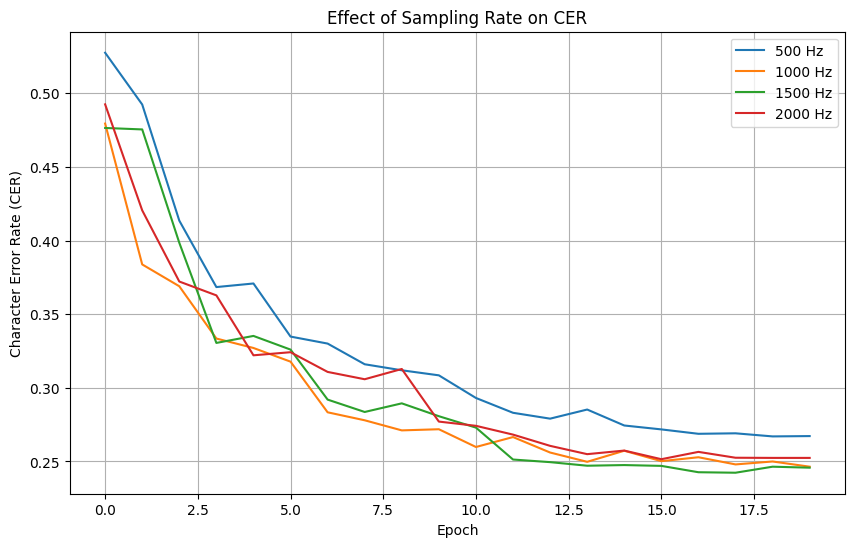

Final CER for different sampling rates:
500 Hz: 0.2672
1000 Hz: 0.2465
1500 Hz: 0.2458
2000 Hz: 0.2524


In [17]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Run sampling rate experiments
sampling_rates = [500, 1000, 1500, 2000]  # Hz
sampling_results = investigate_sampling_rates(
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    sampling_rates=sampling_rates,
    epochs=20  # Use fewer epochs per experiment to save time
)

# Plot results
plt.figure(figsize=(10, 6))
for sr, result in sampling_results.items():
    plt.plot(result['val_cer'], label=f'{sr} Hz')
plt.xlabel('Epoch')
plt.ylabel('Character Error Rate (CER)')
plt.title('Effect of Sampling Rate on CER')
plt.legend()
plt.grid(True)
plt.savefig('sampling_rate_cer.png')
plt.show()

# Print final CERs
print("Final CER for different sampling rates:")
for sr, result in sampling_results.items():
    print(f"{sr} Hz: {result['final_cer']:.4f}")

In [ ]:
''' #Ignore this, it was for the main ConformerCode.
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize the EMGConformer model with better parameters
model = EMGConformer(
    num_classes=99,
    d_model=256,        # Increased from 128 for better representation
    nhead=8,            # Increased from 4 for more attention heads
    num_layers=4,       # Increased from 2 for deeper model
    dropout=0.3         # Reduced from 0.5 to prevent overfitting
)

# Print model architecture and parameter count
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

# Move the model to the device
model = model.to(device)

# Test with a small batch
try:
    print("Testing model with a small batch...")
    # Get a small batch
    test_batch = next(iter(train_loader))
    test_inputs = test_batch['inputs'].to(device)
    test_lengths = test_batch['input_lengths'].to(device)
    
    # Test forward pass
    with torch.no_grad():
        outputs = model(test_inputs, test_lengths)
    
    print(f"Forward pass successful! Output shape: {outputs.shape}")
    
    # Now try the training
    print("Starting training...")
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        epochs=100,      # Train for more epochs
        lr=0.001,        # Better learning rate
        weight_decay=1e-4  # Slightly reduced weight decay
    )
except Exception as e:
    print(f"Error encountered: {type(e).__name__}: {e}")
    
    # Try with small batch only for debugging
    if 'small_train_loader' in globals() and 'small_val_loader' in globals():
        print("Trying with small data loaders for debugging...")
        try:
            history = train_model(
                model=model,
                train_loader=small_train_loader,
                val_loader=small_val_loader,
                device=device,
                epochs=2,  # Just a few epochs
                lr=0.001,
                weight_decay=1e-4
            )
        except Exception as e2:
            print(f"Error with small data loaders: {type(e2).__name__}: {e2}")'''

Using device: cuda
EMGConformer(
  (conv_layers): Sequential(
    (0): Conv1d(1056, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv1d(512, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.3, inplace=False)
  )
  (projection): Identity()
  (pos_encoder): PositionalEncoding()
  (conformer_blocks): ModuleList(
    (0-3): 4 x ConformerBlock(
      (feed_forward1): FeedForwardModule(
        (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (swish): SiLU()
        (dropout1): Dropout(p=0.3, inplace=False)
        (linear2): Lin

Epoch 1/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.07it/s, loss=1.57] 


Epoch 1/100:
  Train Loss: 2.0919
  Val Loss: 0.8590, Val CER: 0.4465


Epoch 2/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.91it/s, loss=1.01]  


Epoch 2/100:
  Train Loss: 0.9006
  Val Loss: 0.6811, Val CER: 0.4057


Epoch 3/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.94it/s, loss=0.573] 


Epoch 3/100:
  Train Loss: 0.7435
  Val Loss: 0.6030, Val CER: 0.3648


Epoch 4/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.59it/s, loss=1]      


Epoch 4/100:
  Train Loss: 0.7000
  Val Loss: 0.6387, Val CER: 0.3820


Epoch 5/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.88it/s, loss=0.669] 


Epoch 5/100:
  Train Loss: 0.6858
  Val Loss: 0.5925, Val CER: 0.3611


Epoch 6/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.72it/s, loss=1.44]  


Epoch 6/100:
  Train Loss: 0.6549
  Val Loss: 0.6599, Val CER: 0.3918


Epoch 7/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.37it/s, loss=0.611] 


Epoch 7/100:
  Train Loss: 0.6352
  Val Loss: 0.5112, Val CER: 0.3410


Epoch 8/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.13it/s, loss=0.603] 


Epoch 8/100:
  Train Loss: 0.5908
  Val Loss: 0.5604, Val CER: 0.3744


Epoch 9/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.51it/s, loss=0.812]  


Epoch 9/100:
  Train Loss: 0.5650
  Val Loss: 0.4639, Val CER: 0.3392


Epoch 10/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.77it/s, loss=0.581]  


Epoch 10/100:
  Train Loss: 0.5257
  Val Loss: 0.4269, Val CER: 0.3234


Epoch 11/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.85it/s, loss=0.415]  


Epoch 11/100:
  Train Loss: 0.4922
  Val Loss: 0.3781, Val CER: 0.3016


Epoch 12/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.68it/s, loss=1.57]  


Epoch 12/100:
  Train Loss: 0.4730
  Val Loss: 0.4046, Val CER: 0.3119


Epoch 13/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.77it/s, loss=0.189] 


Epoch 13/100:
  Train Loss: 0.4221
  Val Loss: 0.4031, Val CER: 0.3128


Epoch 14/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.03it/s, loss=0.487]  


Epoch 14/100:
  Train Loss: 0.4247
  Val Loss: 0.3061, Val CER: 0.2791


Epoch 15/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.85it/s, loss=0.297]   


Epoch 15/100:
  Train Loss: 0.3867
  Val Loss: 0.3147, Val CER: 0.2918


Epoch 16/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.79it/s, loss=1.04]   


Epoch 16/100:
  Train Loss: 0.3778
  Val Loss: 0.3716, Val CER: 0.2887


Epoch 17/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.71it/s, loss=0.232]  


Epoch 17/100:
  Train Loss: 0.3547
  Val Loss: 0.3575, Val CER: 0.2912


Epoch 18/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.94it/s, loss=0.598]  


Epoch 18/100:
  Train Loss: 0.3239
  Val Loss: 0.3399, Val CER: 0.2919


Epoch 19/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.74it/s, loss=0.692]  


Epoch 19/100:
  Train Loss: 0.3465
  Val Loss: 0.3082, Val CER: 0.2795


Epoch 20/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.88it/s, loss=0.404]  


Epoch 20/100:
  Train Loss: 0.3056
  Val Loss: 0.3156, Val CER: 0.2914


Epoch 21/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.94it/s, loss=0.226]  


Epoch 21/100:
  Train Loss: 0.2867
  Val Loss: 0.2574, Val CER: 0.2691


Epoch 22/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.84it/s, loss=0.353]   


Epoch 22/100:
  Train Loss: 0.2773
  Val Loss: 0.2350, Val CER: 0.2666


Epoch 23/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.70it/s, loss=0.236]  


Epoch 23/100:
  Train Loss: 0.2585
  Val Loss: 0.2809, Val CER: 0.2741


Epoch 24/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.95it/s, loss=0.62]   


Epoch 24/100:
  Train Loss: 0.2656
  Val Loss: 0.3732, Val CER: 0.3061


Epoch 25/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.77it/s, loss=0.456]  


Epoch 25/100:
  Train Loss: 0.2379
  Val Loss: 0.3002, Val CER: 0.2629


Epoch 26/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.69it/s, loss=0.266]   


Epoch 26/100:
  Train Loss: 0.2252
  Val Loss: 0.2587, Val CER: 0.2582


Epoch 27/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.84it/s, loss=0.479]  


Epoch 27/100:
  Train Loss: 0.2191
  Val Loss: 0.2563, Val CER: 0.2508


Epoch 28/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.85it/s, loss=0.571]  


Epoch 28/100:
  Train Loss: 0.2143
  Val Loss: 0.3056, Val CER: 0.2729


Epoch 29/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.12it/s, loss=0.432]   


Epoch 29/100:
  Train Loss: 0.1933
  Val Loss: 0.2843, Val CER: 0.2600


Epoch 30/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.21it/s, loss=1.01]    


Epoch 30/100:
  Train Loss: 0.1945
  Val Loss: 0.3115, Val CER: 0.2698


Epoch 31/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.49it/s, loss=1.25]   


Epoch 31/100:
  Train Loss: 0.1804
  Val Loss: 0.2398, Val CER: 0.2606


Epoch 32/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.79it/s, loss=0.525]   


Epoch 32/100:
  Train Loss: 0.1642
  Val Loss: 0.2707, Val CER: 0.2680


Epoch 33/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.43it/s, loss=0.743]   


Epoch 33/100:
  Train Loss: 0.1535
  Val Loss: 0.2571, Val CER: 0.2585


Epoch 34/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.74it/s, loss=0.578]  


Epoch 34/100:
  Train Loss: 0.1485
  Val Loss: 0.2947, Val CER: 0.2671


Epoch 35/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.79it/s, loss=0.889]  


Epoch 35/100:
  Train Loss: 0.1352
  Val Loss: 0.3688, Val CER: 0.2748


Epoch 36/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.71it/s, loss=0.834]  


Epoch 36/100:
  Train Loss: 0.1291
  Val Loss: 0.2855, Val CER: 0.2668


Epoch 37/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.11it/s, loss=0.756]   


Epoch 37/100:
  Train Loss: 0.1148
  Val Loss: 0.3257, Val CER: 0.2667


Epoch 38/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.88it/s, loss=0.633]  


Epoch 38/100:
  Train Loss: 0.1052
  Val Loss: 0.2659, Val CER: 0.2594


Epoch 39/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.97it/s, loss=0.676]  


Epoch 39/100:
  Train Loss: 0.0956
  Val Loss: 0.2680, Val CER: 0.2542


Epoch 40/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.11it/s, loss=0.705] 


Epoch 40/100:
  Train Loss: 0.0942
  Val Loss: 0.3388, Val CER: 0.2687


Epoch 41/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.80it/s, loss=0.823]  


Epoch 41/100:
  Train Loss: 0.0903
  Val Loss: 0.3516, Val CER: 0.2821


Epoch 42/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.98it/s, loss=0.0222]


Epoch 42/100:
  Train Loss: 0.0807
  Val Loss: 0.4436, Val CER: 0.3054


Epoch 43/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.15it/s, loss=0.378]  


Epoch 43/100:
  Train Loss: 0.0660
  Val Loss: 0.2871, Val CER: 0.2648


Epoch 44/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.93it/s, loss=0.41]   


Epoch 44/100:
  Train Loss: 0.0527
  Val Loss: 0.2638, Val CER: 0.2454


Epoch 45/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.03it/s, loss=0.723]  


Epoch 45/100:
  Train Loss: 0.0359
  Val Loss: 0.2622, Val CER: 0.2570


Epoch 46/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.13it/s, loss=0.0643]


Epoch 46/100:
  Train Loss: 0.0429
  Val Loss: 0.4788, Val CER: 0.3211


Epoch 47/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.82it/s, loss=0.529]  


Epoch 47/100:
  Train Loss: 0.0228
  Val Loss: 0.2664, Val CER: 0.2466


Epoch 48/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.12it/s, loss=1.14]   


Epoch 48/100:
  Train Loss: 0.0207
  Val Loss: 0.2744, Val CER: 0.2434


Epoch 49/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.84it/s, loss=0.226] 


Epoch 49/100:
  Train Loss: 0.0103
  Val Loss: 0.2995, Val CER: 0.2574


Epoch 50/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.35it/s, loss=0.731]  


Epoch 50/100:
  Train Loss: 0.0007
  Val Loss: 0.2653, Val CER: 0.2430


Epoch 51/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.90it/s, loss=0.473]  


Epoch 51/100:
  Train Loss: -0.0040
  Val Loss: 0.2683, Val CER: 0.2475


Epoch 52/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.27it/s, loss=0.681]  


Epoch 52/100:
  Train Loss: -0.0049
  Val Loss: 0.3096, Val CER: 0.2609


Epoch 53/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.07it/s, loss=0.0446] 


Epoch 53/100:
  Train Loss: -0.0177
  Val Loss: 0.3217, Val CER: 0.2602


Epoch 54/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.06it/s, loss=1.2]    


Epoch 54/100:
  Train Loss: -0.0218
  Val Loss: 0.3421, Val CER: 0.2626


Epoch 55/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.83it/s, loss=0.394]  


Epoch 55/100:
  Train Loss: -0.0342
  Val Loss: 0.2789, Val CER: 0.2459


Epoch 56/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.02it/s, loss=0.404]  


Epoch 56/100:
  Train Loss: -0.0358
  Val Loss: 0.3599, Val CER: 0.2660


Epoch 57/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.46it/s, loss=0.382]  


Epoch 57/100:
  Train Loss: -0.0389
  Val Loss: 0.2754, Val CER: 0.2344


Epoch 58/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.52it/s, loss=0.72]   


Epoch 58/100:
  Train Loss: -0.0438
  Val Loss: 0.2939, Val CER: 0.2469


Epoch 59/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.71it/s, loss=0.316]  


Epoch 59/100:
  Train Loss: -0.0553
  Val Loss: 0.3484, Val CER: 0.2569


Epoch 60/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.30it/s, loss=0.375]   


Epoch 60/100:
  Train Loss: -0.0595
  Val Loss: 0.3355, Val CER: 0.2532


Epoch 61/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.47it/s, loss=1.78]   


Epoch 61/100:
  Train Loss: -0.0666
  Val Loss: 0.3161, Val CER: 0.2379


Epoch 62/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.98it/s, loss=1.34]    


Epoch 62/100:
  Train Loss: -0.0751
  Val Loss: 0.3172, Val CER: 0.2382


Epoch 63/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.82it/s, loss=0.668]  


Epoch 63/100:
  Train Loss: -0.0855
  Val Loss: 0.3012, Val CER: 0.2370


Epoch 64/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.93it/s, loss=0.737]  


Epoch 64/100:
  Train Loss: -0.0803
  Val Loss: 0.3356, Val CER: 0.2430


Epoch 65/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.24it/s, loss=0.899]   


Epoch 65/100:
  Train Loss: -0.0871
  Val Loss: 0.3660, Val CER: 0.2629


Epoch 66/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.64it/s, loss=0.314]   


Epoch 66/100:
  Train Loss: -0.0940
  Val Loss: 0.2995, Val CER: 0.2360


Epoch 67/100 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.39it/s, loss=0.853]  


Epoch 67/100:
  Train Loss: -0.0981
  Val Loss: 0.3378, Val CER: 0.2468


Epoch 68/100 [Train]:  12%|█▏        | 116/960 [00:05<00:41, 20.27it/s, loss=0.155]  


KeyboardInterrupt: 

In [15]:
all_predictions_lst = history['all_predictions']
all_targets_lst = history['all_targets']

# Make sure this epoch exists in your history
epoch_id = min(60-1, len(all_predictions_lst)-1)  # Get the last epoch by default
print(f"Using results from epoch {epoch_id}")

# Output how many epochs of predictions we have
print(f"Number of epochs with predictions: {len(all_predictions_lst)}")

# Make sure we have predictions for this epoch
if epoch_id < len(all_predictions_lst) and all_predictions_lst[epoch_id]:
    # Get number of samples and choose one that exists
    num_samples = len(all_predictions_lst[epoch_id])
    it = min(12, num_samples-1)  # Default to sample 12 or the last one if fewer
    
    print(f"Number of samples in epoch {epoch_id}: {num_samples}")
    print(f"Sample {it} prediction: {all_predictions_lst[epoch_id][it]}")
    pred = all_predictions_lst[epoch_id][it]
    
    print(f"Number of targets in epoch {epoch_id}: {len(all_targets_lst[epoch_id])}")
    print(f"Sample {it} target: {all_targets_lst[epoch_id][it]}")
    target = all_targets_lst[epoch_id][it]
    
    # Convert indices to characters
    char_set = charset()
    
    # Filter out null class tokens and duplicates from predictions
    filtered_pred = []
    prev = None
    for p in pred:
        if p != char_set.null_class and p != prev:
            filtered_pred.append(p)
        prev = p
    
    pred_chars = char_set.labels_to_str(filtered_pred)
    target_chars = char_set.labels_to_str(target)
    print(f'prediction: {pred_chars}')
    print(f'target    : {target_chars}')
    
    # Show additional examples
    print("\nAdditional examples:")
    for i in range(5):
        sample_idx = min(i, num_samples-1)
        pred = all_predictions_lst[epoch_id][sample_idx]
        target = all_targets_lst[epoch_id][sample_idx]
        
        # Filter out null class tokens and duplicates
        filtered_pred = []
        prev = None
        for p in pred:
            if p != char_set.null_class and p != prev:
                filtered_pred.append(p)
            prev = p
            
        pred_chars = char_set.labels_to_str(filtered_pred)
        target_chars = char_set.labels_to_str(target)
        print(f'Example {i+1}:')
        print(f'  prediction: {pred_chars}')
        print(f'  target    : {target_chars}')
else:
    print(f"No predictions available for epoch {epoch_id}")

Using results from epoch 59
Number of epochs with predictions: 60
Number of samples in epoch 59: 1698
Sample 12 prediction: [ 0  0  0  0  0  7  7  0  0  0  0 19 19 19  0  0  0 14  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0 96 96  0  0  0  0  0  0  0  0  0  0 14
 14 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]
Number of targets in epoch 59: 1698
Sample 12 target: [ 1 17 14 22 13 96  5 14 23 96]
prediction: ahataoa aoa
target    : brown fox 

Additional examples:
Example 1:
  prediction: a
  target    : 
Example 2:
  prediction: a
  target    : 
Example 3:
  prediction: a
  target    : 
Example 4:
  prediction: a
  target    : 
Example 5:
  prediction: a
  target    : 


In [ ]:
'''class SimpleEMGConformer(nn.Module):
    def __init__(self, num_classes=99, d_model=128, nhead=4, num_layers=2, dropout=0.5):
        super().__init__()
        
        # Input EMG signal dimensions
        self.features = 1056  # 2 bands * 16 channels * 33 frequencies
        
        # Enhanced CNN feature extraction
        self.conv_layers = nn.Sequential(
            nn.Conv1d(self.features, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Conv1d(256, d_model, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(d_model),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),  # Only one pooling layer
            nn.Dropout(dropout)
        )
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Simple Transformer encoder layers instead of full Conformer blocks
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model*2,
            dropout=dropout,
            batch_first=False
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(d_model, num_classes)
        )
    
    def forward(self, x, input_lengths=None):
        # x shape: [T, N, B, C, F] - [time, batch, bands, channels, freq]
        T, N, B, C, F = x.shape
        device = x.device
        
        # Flatten features and prepare for Conv1d
        x = x.reshape(T, N, B*C*F).permute(1, 2, 0)  # [N, B*C*F, T]
        
        # Apply CNN layers
        x = self.conv_layers(x)  # [N, d_model, T//2]
        
        # Calculate new sequence lengths after CNN pooling (only one pooling layer)
        if input_lengths is not None:
            new_lengths = torch.div(input_lengths, 2, rounding_mode='floor')
            new_lengths = torch.clamp(new_lengths, min=1)
            # Create padding mask for transformer
            max_len = x.size(2)
            padding_mask = (torch.arange(max_len, device=device).expand(N, max_len) 
                           >= new_lengths.unsqueeze(1))
        else:
            padding_mask = None
        
        # Prepare for transformer: [T//2, N, d_model]
        x = x.permute(2, 0, 1)
        
        # Apply positional encoding
        x = self.pos_encoder(x)
        
        # Apply transformer encoder
        x = self.transformer_encoder(x, src_key_padding_mask=padding_mask)
        
        # Apply classifier
        time_steps, batch_size, hidden_dim = x.size()
        x = x.reshape(-1, hidden_dim)
        x = self.classifier(x)
        x = x.view(time_steps, batch_size, -1)
        
        return x'''